In [ ]:
# Setup for Clipper R kernel

# Make sure both your personal lib and the system libs are visible
.libPaths(c(
  "/mnt/home/bisholea/Rlibs",
  "/opt/gvsu/clipper/2025.05/R/4.4.3/library",
  "/opt/gvsu/clipper/2025.05/spack/apps/linux-rhel9-cascadelake/gcc-13.3.1/r-4.4.3-gz7onk2vbizgd2zxqa6ij47gygl6dsd4/rlib/R/library"
))

# Quick sanity check (optional, just to see)
.libPaths()
"ggplot2" %in% rownames(installed.packages())

# Load the packages you already have
library(readr)
library(dplyr)
library(tidyr)
library(ggplot2)
library(fgsea)
library(cowplot)

[1] "/mnt/home/bisholea/Rlibs"                                                                                                       
[2] "/opt/gvsu/clipper/2025.05/R/4.4.3/library"                                                                                      
[3] "/opt/gvsu/clipper/2025.05/spack/apps/linux-rhel9-cascadelake/gcc-13.3.1/r-4.4.3-gz7onk2vbizgd2zxqa6ij47gygl6dsd4/rlib/R/library"

[1] TRUE


Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union




In [2]:
#!/usr/bin/env Rscript
suppressPackageStartupMessages({
  library(readr); library(dplyr); library(tidyr); library(tibble)
  library(purrr); library(ggplot2)
})

set.seed(1)

# ---------------- paths ----------------
capstone_dir <- "/mnt/projects/debruinz_project/bisholea/capstone"
gsea_dir     <- file.path(capstone_dir, "gsea")
fig_dir      <- file.path(capstone_dir, "figures")
dir.create(fig_dir, showWarnings = FALSE, recursive = TRUE)

# ---------------- load centralized data/style ----------------
fd <- readRDS(file.path(gsea_dir, "figdata.rds"))

# override theme locally for this script
fd$style$theme <- function() {
  ggplot2::theme_classic(base_size = 12, base_family = "serif") +
    ggplot2::theme(
      panel.grid          = ggplot2::element_blank(),
      plot.title.position = "plot",
      legend.title        = ggplot2::element_blank(),
      plot.margin         = ggplot2::margin(t = 3, r = 3, b = 3, l = 3),
      axis.title.x        = ggplot2::element_text(margin = ggplot2::margin(t = 4)),
      axis.title.y        = ggplot2::element_text(margin = ggplot2::margin(r = 4)),
      axis.ticks.length   = grid::unit(2, "pt")
    )
}

# palette + theme from figdata
pal_model <- if (!is.null(fd$palettes$model)) {
  fd$palettes$model
} else {
  c(AE = viridisLite::viridis(7)[4], NMF = "grey75")
}

plt_theme <- fd$style$theme()


save_pdf <- function(path, plot, w=7, h=5) {
  if (isTRUE(capabilities("cairo"))) {
    ggsave(path, plot, width=w, height=h, units="in", device=cairo_pdf, bg="white")
  } else {
    ggsave(path, plot, width=w, height=h, units="in", device="pdf", bg="white", useDingbats=FALSE)
  }
}

read_wide_matrix <- function(path, pathway_col = "pathway") {
  header <- readr::read_lines(path, n_max = 1)
  cols   <- strsplit(header, ",", fixed = TRUE)[[1]]
  pw_col <- if (pathway_col %in% cols) pathway_col else cols[1]
  other  <- setdiff(cols, pw_col)
  ct <- do.call(readr::cols, c(
    setNames(list(readr::col_character()), pw_col),
    setNames(rep(list(readr::col_double()), length(other)), other)
  ))
  df <- readr::read_csv(path, col_types = ct, show_col_types = FALSE)
  rn <- df[[pw_col]]; df[[pw_col]] <- NULL
  m <- as.matrix(df); rownames(m) <- rn; m
}

Warning message:
“No shared levels found between `names(values)` of the manual scale and the
data's colour values.”
Warning message:
“Removed 13 rows containing missing values or values outside the scale range
(`geom_violin()`).”
Warning message:
“No shared levels found between `names(values)` of the manual scale and the
data's colour values.”
Warning message:
“Removed 13 rows containing missing values or values outside the scale range
(`geom_violin()`).”
Warning message:
“No shared levels found between `names(values)` of the manual scale and the
data's colour values.”
Warning message:
“No shared levels found between `names(values)` of the manual scale and the
data's colour values.”


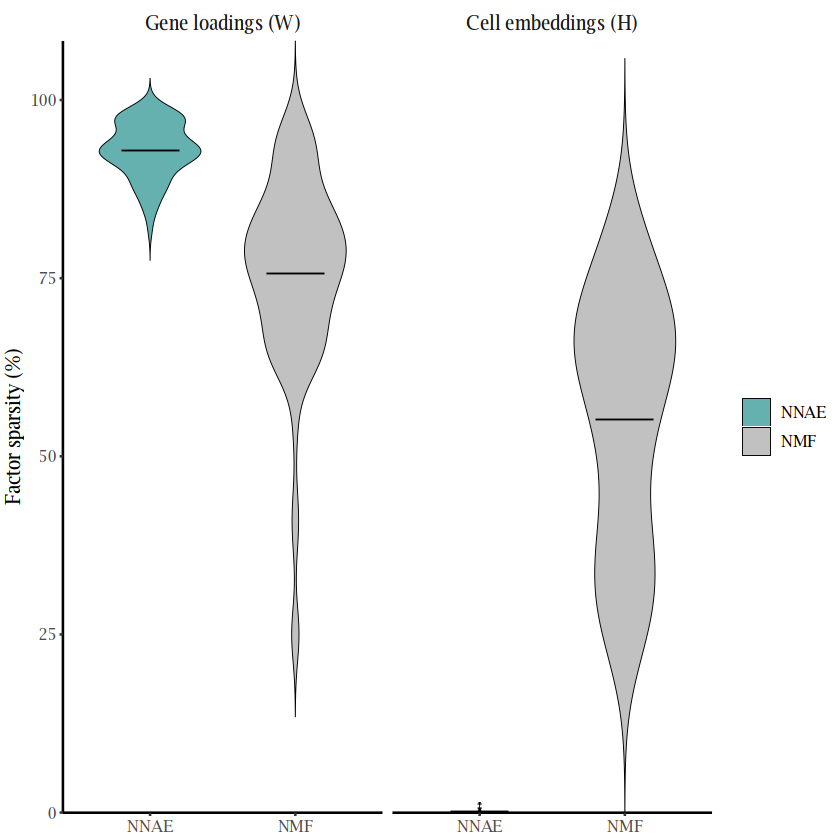

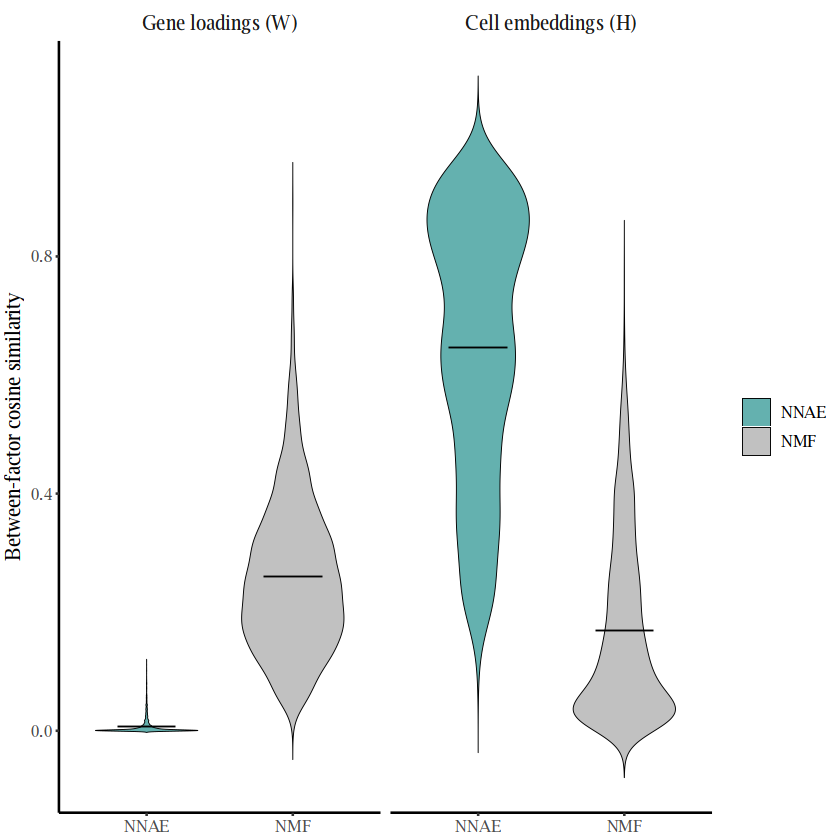

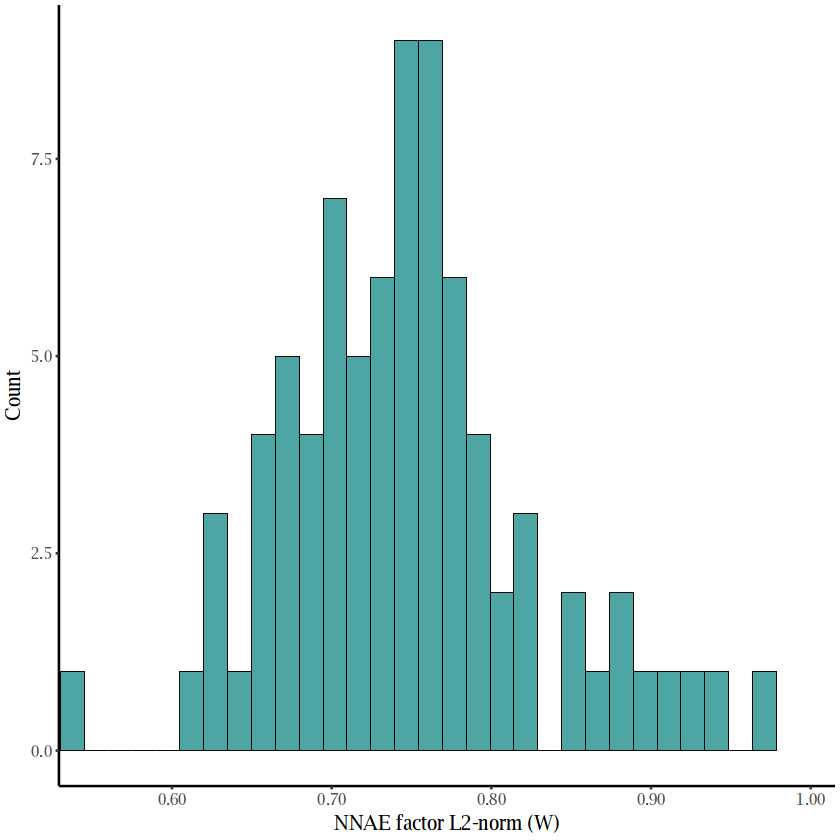

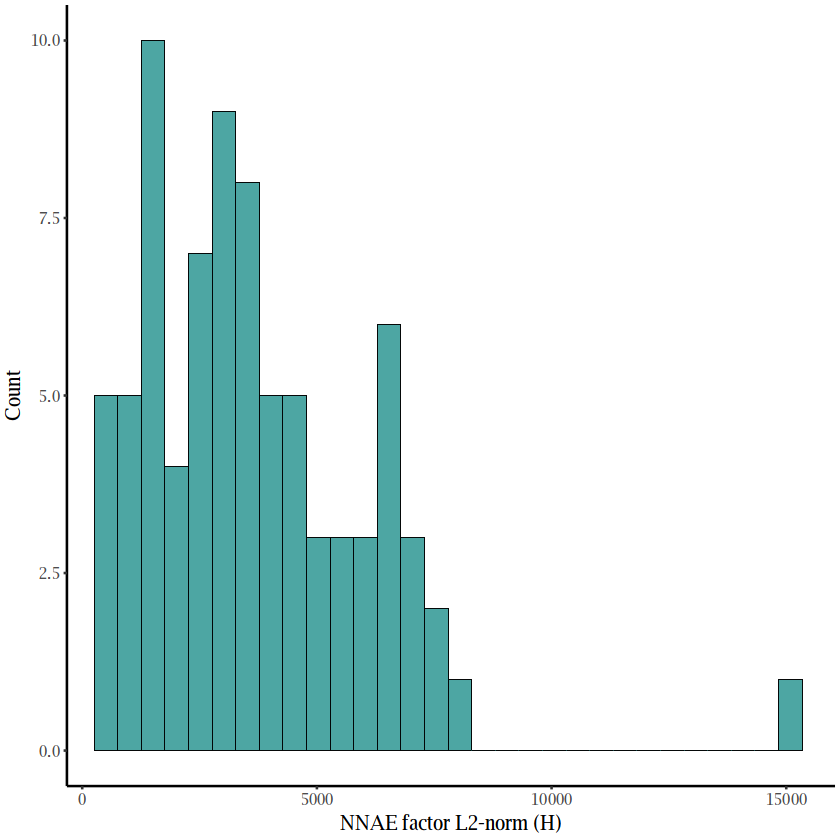

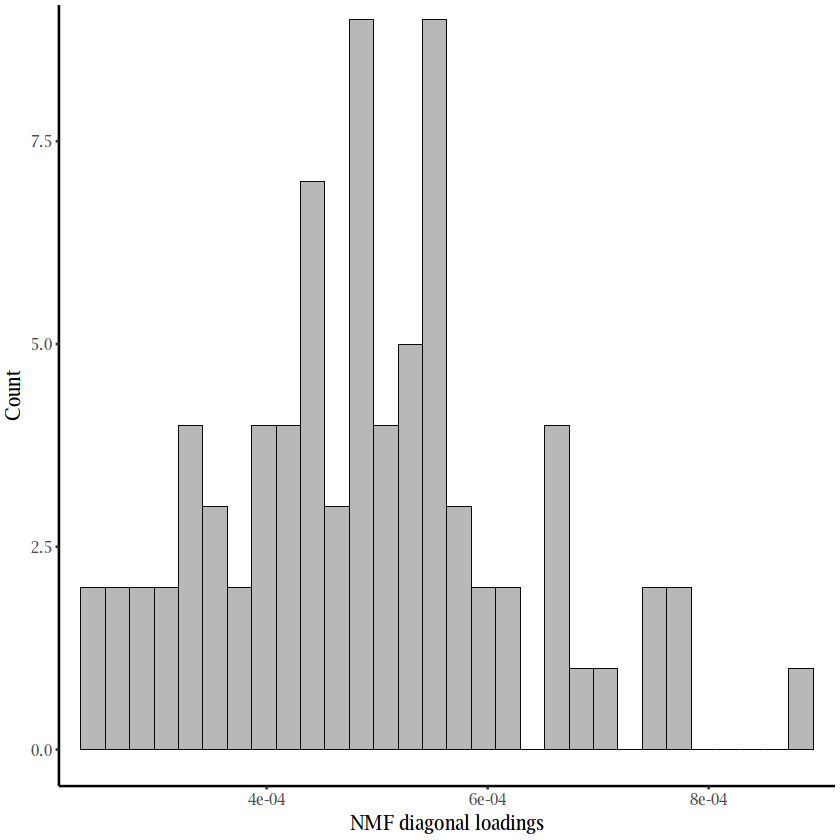

In [9]:
# ==========================================================
# Immune statistical properties for NNAE vs NMF
# ==========================================================

# ---------------- load ----------------
hw_stats <- readr::read_csv(
  file.path(
    capstone_dir,
    "tsv2_benchmarks",
    "immune_k80_nmf_nnae_H_W_stats.csv"
  ),
  show_col_types = FALSE
)

diag_stats <- readr::read_csv(
  file.path(
    capstone_dir,
    "tsv2_benchmarks",
    "immune_k80_nmf_diag_loadings.csv"
  ),
  show_col_types = FALSE
)

# ---------------- clean ----------------
hw_stats <- hw_stats %>%
  dplyr::filter(model %in% c("AE", "NMF")) %>%
  dplyr::mutate(
    model  = factor(model, levels = c("AE", "NMF")),
    matrix = factor(matrix, levels = c("W", "H"))
  )

# pooled across tissues, per (model, matrix, factor)
# (immune has only one "tissue", but leaving this unchanged is fine)
hw_pooled <- hw_stats %>%
  dplyr::group_by(model, matrix, factor) %>%
  dplyr::summarise(
    pct_zero = mean(pct_zero, na.rm = TRUE),
    l2       = mean(l2,       na.rm = TRUE),
    .groups  = "drop"
  )

.model_labels  <- c(AE = "NNAE", NMF = "NMF")
.matrix_labels <- c(W = "Gene loadings (W)", H = "Cell embeddings (H)")

# ==========================================================
# A) Sparsity plot (UNCHANGED): W & H facets, both models
# ==========================================================

df_sparsity <- hw_pooled %>%
  dplyr::filter(is.finite(pct_zero))

p_sparsity_hw <- ggplot(df_sparsity, aes(x = model, y = pct_zero, fill = model)) +
  geom_violin(
    width     = 0.7,
    alpha     = 0.7,
    color     = "black",
    linewidth = 0.2,
    trim      = FALSE,
    scale     = "width"
  ) +
  stat_summary(
    fun       = mean,
    geom      = "crossbar",
    width     = 0.4,
    color     = "black",
    linewidth = 0.3,
    fatten    = 1.3,
    show.legend = FALSE
  ) +
  scale_fill_manual(values = pal_model, labels = .model_labels) +
  scale_color_manual(values = pal_model, labels = .model_labels) +
  scale_x_discrete(labels = .model_labels) +
  scale_y_continuous(
    limits = c(0, NA),
    expand = c(0, 0.02)
  ) +
  facet_wrap(
    ~ matrix,
    nrow = 1,
    labeller = as_labeller(.matrix_labels),
    strip.position = "top"
  ) +
  labs(
    x = NULL,
    y = "Factor sparsity (%)"
  ) +
  plt_theme +
  theme(
    strip.text.x = element_text(size = 12),
    strip.placement = "outside",
    strip.background = element_blank()
  )

save_pdf(file.path(fig_dir, "immune_sparsity_H_W.pdf"), p_sparsity_hw, w = 4.5, h = 3.5)
print(p_sparsity_hw)

# ==========================================================
# B) Between-factor cosine similarity: W & H facets, both models
# ==========================================================

between_stats <- readr::read_csv(
  file.path(capstone_dir, "tsv2_benchmarks", "immune_k80_nmf_nnae_between_factor_cosine.csv"),
  show_col_types = FALSE
)

between_pooled <- between_stats %>%
  dplyr::filter(model %in% c("AE","NMF"), is.finite(cos_sim)) %>%
  dplyr::mutate(
    model  = factor(model, levels = c("AE","NMF")),
    matrix = factor(matrix, levels = c("W","H"))
  ) %>%
  dplyr::group_by(model, matrix) %>%
  dplyr::mutate(cos_sim = as.numeric(cos_sim)) %>%
  dplyr::ungroup()

p_between_hw <- ggplot(between_pooled, aes(x = model, y = cos_sim, fill = model)) +
  geom_violin(
    width     = 0.7,
    alpha     = 0.7,
    color     = "black",
    linewidth = 0.2,
    trim      = FALSE,
    scale     = "width"
  ) +
  stat_summary(
    fun       = mean,
    geom      = "crossbar",
    width     = 0.4,
    color     = "black",
    linewidth = 0.3,
    fatten    = 1.3,
    show.legend = FALSE
  ) +
  scale_fill_manual(values = pal_model, labels = .model_labels) +
  scale_color_manual(values = pal_model, labels = .model_labels) +
  scale_x_discrete(labels = .model_labels) +
  facet_wrap(
    ~ matrix,
    nrow = 1,
    labeller = as_labeller(.matrix_labels),
    strip.position = "top"
  ) +
  labs(
    x = NULL,
    y = "Between-factor cosine similarity"
  ) +
  plt_theme +
  theme(
    strip.text.x = element_text(size = 12),
    strip.placement = "outside",
    strip.background = element_blank()
  )

save_pdf(file.path(fig_dir, "immune_between_factor_similarity_H_W.pdf"), p_between_hw, w = 4.5, h = 3.5)
print(p_between_hw)

# ==========================================================
# C-D) L2 histograms: TWO plots (W and H), NNAE (AE) ONLY
# ==========================================================

df_l2_ae <- hw_pooled %>%
  dplyr::filter(model == "AE", is.finite(l2))

make_l2_hist_ae_by_matrix <- function(df, which_matrix, bins = 30, force_zero = FALSE) {
  df1 <- df %>% dplyr::filter(matrix == which_matrix)
  if (nrow(df1) == 0) return(invisible(NULL))

  v <- df1$l2
  rng <- range(v[is.finite(v)], na.rm = TRUE)

  if (force_zero) rng[1] <- 0  # only if you truly want it

  span <- rng[2] - rng[1]
  if (!is.finite(span) || span == 0) span <- 1
  pad_right <- 0.02 * span

  ggplot(df1, aes(x = l2)) +
    geom_histogram(bins = bins, alpha = 0.8, color = "black", linewidth = 0.2,
                   fill = pal_model[["AE"]]) +
    coord_cartesian(xlim = c(rng[1], rng[2] + pad_right)) +
    labs(x = paste0("NNAE factor L2-norm (", which_matrix, ")"), y = "Count") +
    plt_theme
}

library(scales)

# ---- W: plot actual L2 (no delta) ----
dfW <- df_l2_ae %>%
  dplyr::filter(matrix == "W")

p_l2_W <- make_l2_hist_ae_by_matrix(df_l2_ae, "W", bins = 30) +
  scale_x_continuous(
    labels = scales::label_number(accuracy = 0.01),
    expand = expansion(mult = c(0.02, 0.08))
  )

  
# ---- H: unchanged ----
p_l2_H <- make_l2_hist_ae_by_matrix(df_l2_ae, "H", bins = 30)

if (!is.null(p_l2_W)) {
  save_pdf(file.path(fig_dir, "immune_AE_L2_hist_W.pdf"), p_l2_W, w = 4.5, h = 3.5)
  ggsave(file.path(fig_dir, "immune_AE_L2_hist_W.png"),
         p_l2_W, width = 4.5, height = 3.5, units = "in", dpi = 300, bg = "white")
  print(p_l2_W)
}

if (!is.null(p_l2_H)) {
  save_pdf(file.path(fig_dir, "immune_AE_L2_hist_H.pdf"), p_l2_H, w = 4.5, h = 3.5)
  ggsave(file.path(fig_dir, "immune_AE_L2_hist_H.png"),
         p_l2_H, width = 4.5, height = 3.5, units = "in", dpi = 300, bg = "white")
  print(p_l2_H)
}


# ==========================================================
# E) NMF diagonal loadings histogram (unchanged style)
# ==========================================================

diag_stats_nmf <- diag_stats %>%
  dplyr::filter(model == "NMF") %>%
  dplyr::filter(is.finite(diag_loading))

p_diag <- ggplot(diag_stats_nmf, aes(x = diag_loading)) +
  geom_histogram(
    bins      = 30,
    color     = "black",
    linewidth = 0.2,
    alpha     = 0.8,
    fill      = pal_model[["NMF"]]
  ) +
  scale_x_continuous(expand = expansion(mult = c(0.03, 0.03))) +
  scale_y_continuous(limits = c(0, NA), expand = expansion(mult = c(0.05, 0.02))) +
  labs(
    x = "NMF diagonal loadings",
    y = "Count"
  ) +
  plt_theme

save_pdf(file.path(fig_dir, "immune_nmf_diag_loadings_hist.pdf"), p_diag, w = 4.5, h = 3.5)
print(p_diag)


Warning message:
“No shared levels found between `names(values)` of the manual scale and the
data's colour values.”
Warning message:
“Removed 13 rows containing missing values or values outside the scale range
(`geom_violin()`).”
Warning message in get_plot_component(plot, "guide-box"):
“Multiple components found; returning the first one. To return all, use `return_all = TRUE`.”
Warning message:
“No shared levels found between `names(values)` of the manual scale and the
data's colour values.”
Warning message:
“Removed 13 rows containing missing values or values outside the scale range
(`geom_violin()`).”
Warning message:
“No shared levels found between `names(values)` of the manual scale and the
data's colour values.”


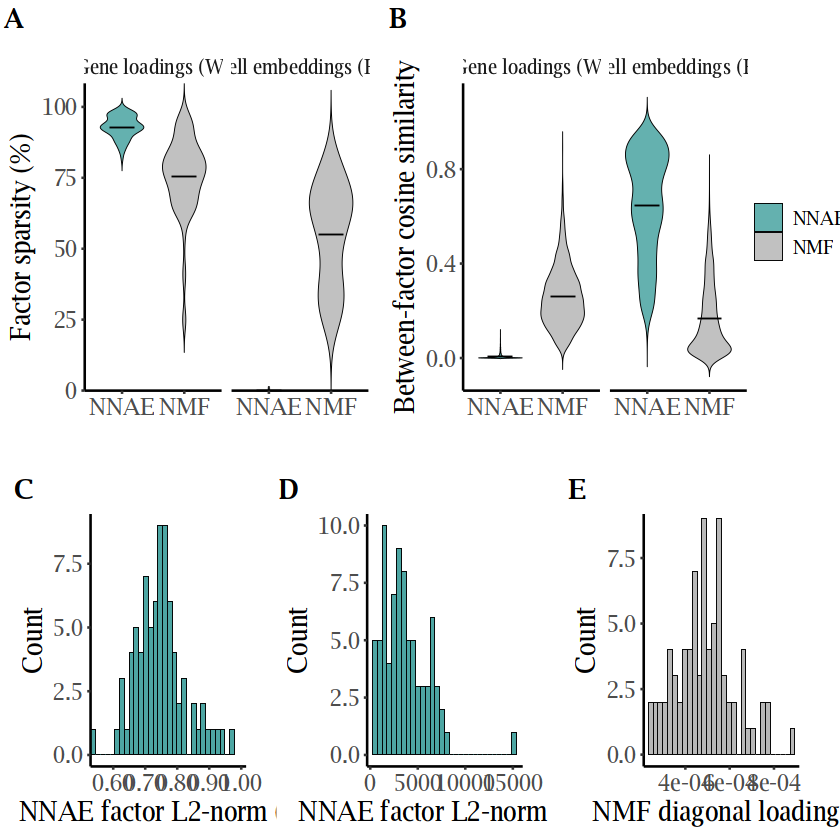

In [10]:
library(cowplot)
library(ggplot2)

# =========================
# 0) Helpers
# =========================
sp <- ggplot() + theme_void()

fig_tag_theme <- theme(
  legend.position = "none",
  axis.title.x = element_text(family = "serif", size = 16),
  axis.title.y = element_text(family = "serif", size = 16),
  axis.text.x  = element_text(family = "serif", size = 14),
  axis.text.y  = element_text(family = "serif", size = 14),
  plot.tag     = element_text(family = "serif", face = "bold", size = 16),
  plot.tag.position = c(0.01, 1.08),
  plot.margin       = margin(t = 30, r = 6, b = 8, l = 6)
)

# =========================
# Tag plots (IMMUNE)
# =========================
pA_tag <- p_sparsity_hw + fig_tag_theme + labs(tag = "A", x = " ")
pB_tag <- p_between_hw  + fig_tag_theme + labs(tag = "B", x = " ")
pC_tag <- p_l2_W        + fig_tag_theme + labs(tag = "C")
pD_tag <- p_l2_H        + fig_tag_theme + labs(tag = "D")
pE_tag <- p_diag        + fig_tag_theme + labs(tag = "E")

# =========================
# 1) Shared legend (grab from one of the violins)
# =========================
leg_shared <- get_legend(
  p_sparsity_hw +
    theme(
      legend.position = "right",
      legend.title    = element_blank(),
      text            = element_text(family = "serif", size = 14)
    )
)

# =========================
# 2) Align the two top violins so axes line up nicely
# =========================
top_aligned <- align_plots(pA_tag, pB_tag, align = "hv", axis = "tblr")
pA_al <- top_aligned[[1]]
pB_al <- top_aligned[[2]]

# =========================
# 3) Make TOP row: 2 plots + legend
# =========================
row_top <- plot_grid(
  pA_al, pB_al, leg_shared,
  nrow       = 1,
  rel_widths = c(1, 1, 0.22)
)

# =========================
# 4) Make BOTTOM row: 3 histograms (skinnier)
# =========================
bottom_aligned <- align_plots(pC_tag, pD_tag, pE_tag, align = "hv", axis = "tblr")
pC_al <- bottom_aligned[[1]]
pD_al <- bottom_aligned[[2]]
pE_al <- bottom_aligned[[3]]

row_bottom <- plot_grid(
  pC_al, sp, pD_al, sp, pE_al, sp,
  nrow       = 1,
  rel_widths = c(1, 0.08, 1, 0.08, 1, 0.12)
)

# =========================
# 5) Stack rows: 2 on top, 3 on bottom
# =========================
fig_immune <- plot_grid(
  row_top,
  row_bottom,
  ncol        = 1,
  rel_heights = c(1.05, 0.85)
)

print(fig_immune)

# =========================
# 6) Save
# =========================
save_pdf(
  file.path(fig_dir, "figure_immune_stats_panel.pdf"),
  fig_immune,
  w = 9,
  h = 2 * 3.5
)

ggsave(
  file.path(fig_dir, "figure_immune_stats_panel.png"),
  fig_immune,
  width  = 9,
  height = 2 * 3.5,
  units  = "in",
  dpi    = 300,
  bg     = "white"
)
